In [ ]:
%%capture
%run '/content/drive/MyDrive/Federated_Learning/MNIST/NonIID/DirichletPartition/Decentralized/MNIST_Dirichlet_Requirement.ipynb'

In [3]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images,labels=batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            if images.size(0)<=1:
                continue
            else:
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (torch.max(outputs.data,1)[1]==labels).sum().item()

        if total>0:
            epoch_loss /= total
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

In [4]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [5]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [6]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [7]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [8]:
from flwr.server.strategy import FedAvgM # Federated average with momentum

test_accuracies = []

class CustomFedAvgM(FedAvgM):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [9]:
params = get_parameters(Net())
from flwr.common import ndarrays_to_parameters

In [10]:
strategy = CustomFedAvgM(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    initial_parameters=ndarrays_to_parameters(params),
    server_learning_rate=1.0, #Learning rate
    server_momentum=0.9 #Momentum
)

In [11]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [12]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [13]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=1741) 2025-04-27 20:34:40.650863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1741) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1741) E0000 00:00:1745786080.692617    1741 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1741) E0000 00:00:1745786080.704344    1741 cuda_bla

(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 15852129404057363516, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1741)   array_records={},
(ClientAppActor pid=1741)   metric_records={},
(ClientAppActor pid=1741)   config_records={}
(ClientAppActor pid=1741) ), 'run_config': {}}
(ClientAppActor pid=1741) Using partition_id: 6


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 164489.61 examples/s]


(ClientAppActor pid=1741) Partition 6 size: 674
(ClientAppActor pid=1741) Partition 6 train size: 539
(ClientAppActor pid=1741) Partition 6 test size: 135
(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 16783721351695271952, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=1741)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1741)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1741)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1741) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1741) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=1742) Partition 5 s

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 8181115729022554765, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1741)   array_records={},
(ClientAppActor pid=1741)   metric_records={},
(ClientAppActor pid=1741)   config_records={}
(ClientAppActor pid=1741) ), 'run_config': {}}
(ClientAppActor pid=1741) Using partition_id: 5
(ClientAppActor pid=1742) Partition 3 size: 5718
(ClientAppActor pid=1742) Partition 3 train size: 4574
(ClientAppActor pid=1742) Partition 3 test size: 1144
(ClientAppActor pid=1742) Partition 1 size: 1060
(ClientAppActor pid=1742) Partition 1 train size: 848
(ClientAppActor pid=1742) Partition 1 test size: 212
(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 16783721351695271952, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1741)   array_records={}, [repeate

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Accuracy: 0.7185
(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 8181115729022554765, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1741)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1741)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1741)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1741) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1741) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=1741) Partition 5 size: 4995 [repeated 2x across cluster]
(ClientAppActor pid=1741) Partition 5 train size: 3996 [repeated 2x across cluster]
(ClientAppActor pid=1741) Partition 5 test size: 999 [repeated 2x across cluster]
(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 15852129404057363516, 'node_config': {'partition-

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 2021566547169341152, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1741)   array_records={},
(ClientAppActor pid=1741)   metric_records={},
(ClientAppActor pid=1741)   config_records={}
(ClientAppActor pid=1741) ), 'run_config': {}}
(ClientAppActor pid=1741) Using partition_id: 2
(ClientAppActor pid=1742) Partition 3 size: 5718
(ClientAppActor pid=1742) Partition 3 train size: 4574
(ClientAppActor pid=1742) Partition 3 test size: 1144
(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 12445855703291514090, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1741)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1741)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1741)   config_records={} [repeated 2x 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.7075
(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 8181115729022554765, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1741)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1741)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1741)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1741) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1741) Using partition_id: 5 [repeated 3x across cluster]
(ClientAppActor pid=1741) Partition 5 size: 4995 [repeated 3x across cluster]
(ClientAppActor pid=1741) Partition 5 train size: 3996 [repeated 3x across cluster]
(ClientAppActor pid=1741) Partition 5 test size: 999 [repeated 3x across cluster]
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 15852129404057363516, 'node_config': {'partition-

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 5840698320404870875, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1741)   array_records={},
(ClientAppActor pid=1741)   metric_records={},
(ClientAppActor pid=1741)   config_records={}
(ClientAppActor pid=1741) ), 'run_config': {}}
(ClientAppActor pid=1741) Using partition_id: 5
(ClientAppActor pid=1742) Partition 5 size: 4995
(ClientAppActor pid=1742) Partition 5 train size: 3996
(ClientAppActor pid=1742) Partition 5 test size: 999
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 15852129404057363516, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1742)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1742)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1742)   config_records={} [repeated 2x a

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.9313
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 11086049140047355101, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1742)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1742)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1742)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1742) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1742) Using partition_id: 1 [repeated 3x across cluster]
(ClientAppActor pid=1742) Partition 5 size: 4995 [repeated 2x across cluster]
(ClientAppActor pid=1742) Partition 5 train size: 3996 [repeated 2x across cluster]
(ClientAppActor pid=1742) Partition 5 test size: 999 [repeated 2x across cluster]
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 12445855703291514090, 'node_config': {'partition

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 11086049140047355101, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1741)   array_records={},
(ClientAppActor pid=1741)   metric_records={},
(ClientAppActor pid=1741)   config_records={}
(ClientAppActor pid=1741) ), 'run_config': {}}
(ClientAppActor pid=1741) Using partition_id: 1
(ClientAppActor pid=1742) Partition 5 size: 4995
(ClientAppActor pid=1742) Partition 5 train size: 3996
(ClientAppActor pid=1742) Partition 5 test size: 999
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 2021566547169341152, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1742)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1742)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1742)   config_records={} [repeated 3x a

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.9202
(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 5840698320404870875, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1741)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1741)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1741)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1741) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1741) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=1742) Partition 5 size: 4995 [repeated 3x across cluster]
(ClientAppActor pid=1742) Partition 5 train size: 3996 [repeated 3x across cluster]
(ClientAppActor pid=1742) Partition 5 test size: 999 [repeated 3x across cluster]
(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 15887688244313073503, 'node_config': {'partition-

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 16783721351695271952, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1741)   array_records={},
(ClientAppActor pid=1741)   metric_records={},
(ClientAppActor pid=1741)   config_records={}
(ClientAppActor pid=1741) ), 'run_config': {}}
(ClientAppActor pid=1741) Using partition_id: 2
(ClientAppActor pid=1742) Partition 2 size: 2538
(ClientAppActor pid=1742) Partition 2 train size: 2030
(ClientAppActor pid=1742) Partition 2 test size: 508
(ClientAppActor pid=1742) Partition 5 size: 4995
(ClientAppActor pid=1742) Partition 5 train size: 3996
(ClientAppActor pid=1742) Partition 5 test size: 999
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 11315350189748085785, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1742)   array_records={}, [repeat

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.9317
(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 8181115729022554765, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1741)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1741)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1741)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1741) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1741) Using partition_id: 5 [repeated 2x across cluster]
(ClientAppActor pid=1742) Partition 1 size: 1060 [repeated 3x across cluster]
(ClientAppActor pid=1742) Partition 1 train size: 848 [repeated 3x across cluster]
(ClientAppActor pid=1742) Partition 1 test size: 212 [repeated 3x across cluster]
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 15852129404057363516, 'node_config': {'partition-i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 8181115729022554765, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1741)   array_records={},
(ClientAppActor pid=1741)   metric_records={},
(ClientAppActor pid=1741)   config_records={}
(ClientAppActor pid=1741) ), 'run_config': {}}
(ClientAppActor pid=1741) Using partition_id: 5
(ClientAppActor pid=1742) Partition 6 size: 674
(ClientAppActor pid=1742) Partition 6 train size: 539
(ClientAppActor pid=1742) Partition 6 test size: 135
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 15887688244313073503, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1742)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1742)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1742)   config_records={} [repeated 2x acr

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.9232
(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 16783721351695271952, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1741)   array_records={},
(ClientAppActor pid=1741)   metric_records={},
(ClientAppActor pid=1741)   config_records={}
(ClientAppActor pid=1741) ), 'run_config': {}}
(ClientAppActor pid=1741) Using partition_id: 2
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 15852129404057363516, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1742)   array_records={},
(ClientAppActor pid=1742)   metric_records={},
(ClientAppActor pid=1742)   config_records={}
(ClientAppActor pid=1742) ), 'run_config': {}}
(ClientAppActor pid=1742) Using partition_id: 6
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 15887688244313073503, 'node_config': {'partitio

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 15852129404057363516, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1741)   array_records={},
(ClientAppActor pid=1741)   metric_records={},
(ClientAppActor pid=1741)   config_records={}
(ClientAppActor pid=1741) ), 'run_config': {}}
(ClientAppActor pid=1741) Using partition_id: 6
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 11086049140047355101, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1742)   array_records={},
(ClientAppActor pid=1742)   metric_records={},
(ClientAppActor pid=1742)   config_records={}
(ClientAppActor pid=1742) ), 'run_config': {}}
(ClientAppActor pid=1742) Using partition_id: 1
(ClientAppActor pid=1741) Partition 6 size: 674
(ClientAppActor pid=1741) Partition 6 train size: 539
(ClientAppActor pid=1741) Partition 6 test size: 135
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.5727
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 11086049140047355101, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1742)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1742)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1742)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1742) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1742) Using partition_id: 1 [repeated 3x across cluster]
(ClientAppActor pid=1742) Partition 1 size: 1060 [repeated 2x across cluster]
(ClientAppActor pid=1742) Partition 1 train size: 848 [repeated 2x across cluster]
(ClientAppActor pid=1742) Partition 1 test size: 212 [repeated 2x across cluster]
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 8181115729022554765, 'node_config': {'partition-i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 11086049140047355101, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1741)   array_records={},
(ClientAppActor pid=1741)   metric_records={},
(ClientAppActor pid=1741)   config_records={}
(ClientAppActor pid=1741) ), 'run_config': {}}
(ClientAppActor pid=1741) Using partition_id: 1
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 15852129404057363516, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1742)   array_records={},
(ClientAppActor pid=1742)   metric_records={},
(ClientAppActor pid=1742)   config_records={}
(ClientAppActor pid=1742) ), 'run_config': {}}
(ClientAppActor pid=1742) Using partition_id: 6
(ClientAppActor pid=1741) Partition 1 size: 1060
(ClientAppActor pid=1741) Partition 1 train size: 848
(ClientAppActor pid=1741) Partition 1 test size: 212
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.5903
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 8181115729022554765, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 4x across cluster]
(ClientAppActor pid=1742)   array_records={}, [repeated 4x across cluster]
(ClientAppActor pid=1742)   metric_records={}, [repeated 4x across cluster]
(ClientAppActor pid=1742)   config_records={} [repeated 4x across cluster]
(ClientAppActor pid=1742) ), 'run_config': {}} [repeated 4x across cluster]
(ClientAppActor pid=1742) Using partition_id: 5 [repeated 4x across cluster]
(ClientAppActor pid=1741) Partition 5 size: 4995 [repeated 2x across cluster]
(ClientAppActor pid=1741) Partition 5 train size: 3996 [repeated 3x across cluster]
(ClientAppActor pid=1741) Partition 5 test size: 999 [repeated 3x across cluster]
(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 15852129404057363516, 'node_config': {'partition-

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 16783721351695271952, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1741)   array_records={},
(ClientAppActor pid=1741)   metric_records={},
(ClientAppActor pid=1741)   config_records={}
(ClientAppActor pid=1741) ), 'run_config': {}}
(ClientAppActor pid=1741) Using partition_id: 2
(ClientAppActor pid=1742) Partition 5 size: 4995
(ClientAppActor pid=1742) Partition 5 train size: 3996
(ClientAppActor pid=1742) Partition 5 test size: 999
(ClientAppActor pid=1741) Partition 2 size: 2538
(ClientAppActor pid=1741) Partition 2 train size: 2030
(ClientAppActor pid=1741) Partition 2 test size: 508
(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 15887688244313073503, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1741)   array_records={}, [repeat

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.9666
(ClientAppActor pid=1742) Partition 1 size: 1060
(ClientAppActor pid=1742) Partition 1 train size: 848
(ClientAppActor pid=1742) Partition 1 test size: 212
(ClientAppActor pid=1741) Partition 5 size: 4995
(ClientAppActor pid=1741) Partition 5 train size: 3996
(ClientAppActor pid=1741) Partition 5 test size: 999
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 15852129404057363516, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1742)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1742)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1742)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1742) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1742) Using partition_id: 6 [repeated 3x across cluster]
(ClientAppActor pid=1742) Partition 6 size: 674
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 11086049140047355101, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1741)   array_records={},
(ClientAppActor pid=1741)   metric_records={},
(ClientAppActor pid=1741)   config_records={}
(ClientAppActor pid=1741) ), 'run_config': {}}
(ClientAppActor pid=1741) Using partition_id: 1
(ClientAppActor pid=1742) Partition 0 size: 544
(ClientAppActor pid=1742) Partition 0 train size: 435
(ClientAppActor pid=1742) Partition 0 test size: 109
(ClientAppActor pid=1742) Partition 3 size: 5718
(ClientAppActor pid=1742) Partition 3 train size: 4574
(ClientAppActor pid=1742) Partition 3 test size: 1144
(ClientAppActor pid=1742) Context data: {'run_id': 15686409291747166429, 'node_id': 11315350189748085785, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1742)   array_records={}, [repeate

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 1655.63s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.04803924926849937
INFO :      		round 2: 0.03528658075374683
INFO :      		round 3: 0.03284288678502457
INFO :      		round 4: 0.027089614440424122
INFO :      		round 5: 0.018365720671170708
INFO :      		round 6: 0.01317490127179051
INFO :      		round 7: 0.0654569713301197
INFO :      		round 8: 0.1442979459961713
INFO :      		round 9: 0.010036168996371482
INFO :      		round 10: 0.06311785113317823
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.7185011954782582),
INFO :      	              (2, 0.7075482570946682),
INFO :      	              (3, 0.9313479978396864),
INFO :      	              (4, 0.9201619128753111),
INFO :      	              (5, 0.9317312299422269),
INFO :      	              (6, 0.923194784163093),
INFO :    

Round 10: Test Accuracy: 0.8709
(ClientAppActor pid=1741) Context data: {'run_id': 15686409291747166429, 'node_id': 189152134889704616, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1741)   array_records={},
(ClientAppActor pid=1741)   metric_records={},
(ClientAppActor pid=1741)   config_records={}
(ClientAppActor pid=1741) ), 'run_config': {}}
(ClientAppActor pid=1741) Using partition_id: 6
(ClientAppActor pid=1741) Partition 6 size: 674
(ClientAppActor pid=1741) Partition 6 train size: 539
(ClientAppActor pid=1741) Partition 6 test size: 135


(ClientAppActor pid=1742) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=1742) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=1742) see the appropriate new directories, set the environment variable
(ClientAppActor pid=1742) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=1742) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=1742)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


In [14]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.7185
Round 2: 0.7075
Round 3: 0.9313
Round 4: 0.9202
Round 5: 0.9317
Round 6: 0.9232
Round 7: 0.5727
Round 8: 0.5903
Round 9: 0.9666
Round 10: 0.8709



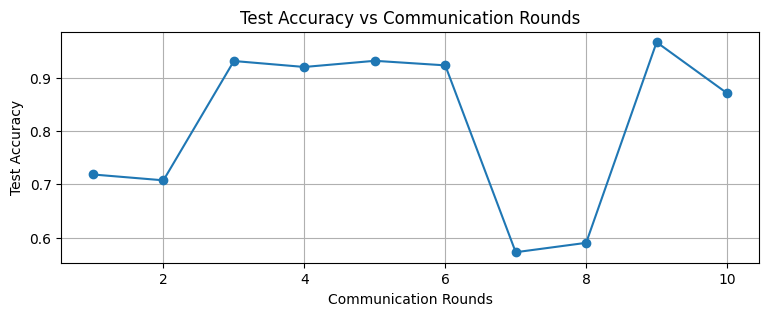

In [15]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()